  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



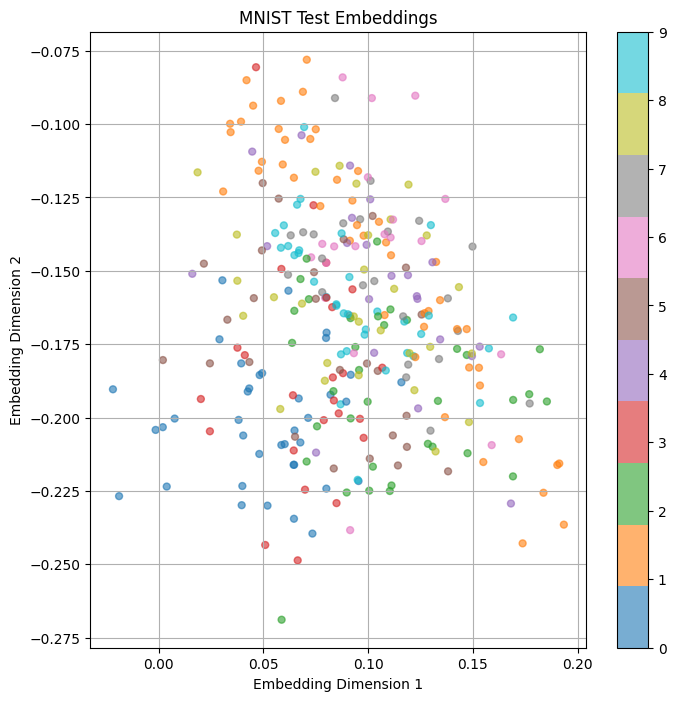

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import random

# Define the Siamese Network Architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5), nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 2)
        )

    def forward_once(self, x):
        output = self.convnet(x)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
model = SiameseNetwork().to(device)

# Dummy weight initialization for demonstration purposes
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

# Apply the weights initialization
model.apply(weights_init)

# Load a small subset of MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a subset of 300 random samples
indices = random.sample(range(len(mnist_dataset)), 300)
mnist_subset = Subset(mnist_dataset, indices)
data_loader = DataLoader(mnist_subset, batch_size=100, shuffle=True)

# Function to generate embeddings from the model
def get_embeddings(loader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            output = model.forward_once(data)  # Use only one side of the Siamese network for embeddings
            embeddings.append(output)
            labels.append(target)

    embeddings = torch.cat(embeddings).cpu().numpy()
    labels = torch.cat(labels).numpy()
    return embeddings, labels

# Get embeddings
embeddings, labels = get_embeddings(data_loader, model)

# Plotting function for embeddings
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', s=25, alpha=0.6)
    plt.colorbar(scatter)
    plt.title("MNIST Test Embeddings")
    plt.xlabel("Embedding Dimension 1")
    plt.ylabel("Embedding Dimension 2")
    plt.grid(True)
    plt.show()

# Generate the plot
plot_embeddings(embeddings, labels)


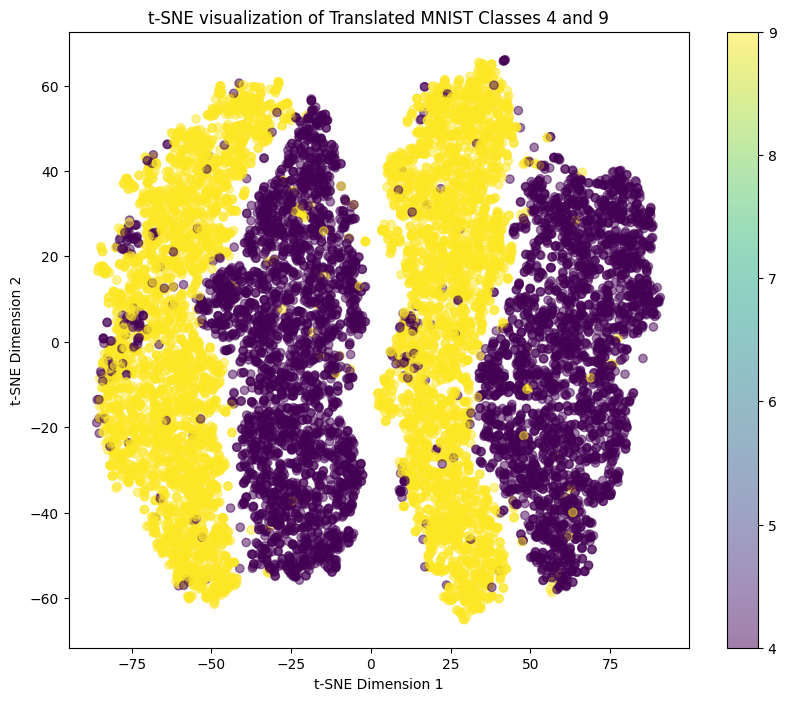

In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

# Filter for digits 4 and 9
indices = (mnist.targets == 4) | (mnist.targets == 9)
filtered_data = mnist.data[indices]
filtered_targets = mnist.targets[indices]

# Function to translate images
def translate_image(image, shift, horizontal=True):
    if horizontal:
        translated = torch.roll(image, shifts=shift, dims=1)  # horizontal shift
    else:
        translated = torch.roll(image, shifts=shift, dims=0)  # vertical shift
    return translated

# Translate images randomly
translated_images = torch.stack([translate_image(img, 5, i % 2 == 0) for i, img in enumerate(filtered_data)])

# Flatten the data for t-SNE
data_flat = translated_images.view(translated_images.shape[0], -1).numpy()
labels = filtered_targets.numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(data_flat)

# Plotting the results
def plot_tsne(data, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title("t-SNE visualization of Translated MNIST Classes 4 and 9")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

plot_tsne(transformed_data, labels)


In [5]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=False)
loader = DataLoader(mnist_dataset, batch_size=10000, shuffle=False)

# Fetch a batch of images and labels
images, labels = next(iter(loader))

# Filter out labels for 4 and 9 and apply translation
indices = (labels == 4) | (labels == 9)
images = images[indices]
labels = labels[indices]

# Function to translate images
def translate_images(images, shift=2):
    # Define translations
    translations = [(shift, 0), (0, shift), (-shift, 0), (0, -shift)]
    translated = []
    for image in images:
        # Randomly choose a translation
        trans = translations[np.random.randint(0, len(translations))]
        # Apply the translation
        translated_img = torch.roll(image, shifts=trans, dims=(2, 3))
        translated.append(translated_img)
    return torch.stack(translated)

# Apply translation
translated_images = translate_images(images)

# Flatten and scale the data
data_flat = translated_images.view(translated_images.size(0), -1).numpy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_flat)

# Apply t-SNE with adjusted hyperparameters
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=5000, random_state=42)
transformed_data = tsne.fit_transform(data_scaled)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, cmap='Spectral', alpha=0.5)
plt.colorbar()
plt.title('t-SNE visualization of MNIST Classes 4 and 9 after Translation')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Assuming the input size is 32x32, as mentioned in the image
        # Layer 1: Convolutional layer with subsampling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=15, kernel_size=6, stride=1, padding=2), # Output size: 32x32 -> 27x27
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 27x27 -> 13x13
        )
        # Layer 2: Convolutional layer with subsampling
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=5, stride=1, padding=0), # Output size: 13x13 -> 9x9
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output size: 9x9 -> 4x4
        )
        # Layer 3: Convolutional layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=30, kernel_size=4, stride=1, padding=0), # Output size: 4x4 -> 1x1
            nn.ReLU()
        )
        # Output layer: Fully connected layer
        self.fc = nn.Linear(30 * 1 * 1, 2) # Assuming the final output is 2x1x1 as per image

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

# Create the model
model = CustomCNN()

# Print the model architecture
print(model)


CustomCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(15, 30, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
  )
  (fc): Linear(in_features=30, out_features=2, bias=True)
)


In [7]:
!pip install torchsummary


In [8]:
from torchsummary import summary

# Assuming CustomCNN is defined as per previous instructions and the input size is 32x32
model = CustomCNN()

# Set the device as CPU since `torchsummary` expects a device
# device = torch.device("cpu")

# Print the model summary
summary(model.to(device), (1, 32, 32))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x120 and 30x2)

In [9]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 15, kernel_size=6, padding=2)
        self.layer2 = nn.Conv2d(15, 15, kernel_size=5)
        self.layer3 = nn.Conv2d(15, 30, kernel_size=4)
        self.fc = nn.Linear(30, 2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.layer2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.layer3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Instantiate the model
model = CustomCNN()

# Print the model architecture
print(model)


CustomCNN(
  (layer1): Conv2d(1, 15, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  (layer2): Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1))
  (layer3): Conv2d(15, 30, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=30, out_features=2, bias=True)
)


In [10]:
from torchsummary import summary

# Assuming the input size is 32x32
summary(model, (1, 32, 32))


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [11]:
import torch
import torch.nn as nn

# Define the CNN architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Conv2d(1, 15, kernel_size=6, padding=2)  # Output: 15x27x27
        self.pool = nn.MaxPool2d(2, 2)                            # Output: 15x13x13 (pooling halved the dimensions)
        self.layer2 = nn.Conv2d(15, 15, kernel_size=5)            # Output: 15x9x9
        self.layer3 = nn.Conv2d(15, 30, kernel_size=5)            # Output: 30x5x5
        self.fc = nn.Linear(30 * 1 * 1, 2)                        # Output: 2

    def forward(self, x):
        x = self.pool(F.relu(self.layer1(x)))
        x = self.pool(F.relu(self.layer2(x)))
        x = F.relu(self.layer3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = self.fc(x)
        return x

# Instantiate the model
model = CustomCNN()

# Custom function to print the model architecture in a tree-like manner
def print_model_tree(module, indent=''):
    print(indent + module.__class__.__name__)
    indent += '  '
    for name, child in module.named_children():
        if not list(child.children()):  # If it is a leaf module
            print(f"{indent}{name}: {child}")
        else:  # If it is an intermediate module
            print(f"{indent}{name}:")
            print_model_tree(child, indent + '  ')

# Print the architecture tree
print_model_tree(model)


CustomCNN
  layer1: Conv2d(1, 15, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2))
  pool: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  layer2: Conv2d(15, 15, kernel_size=(5, 5), stride=(1, 1))
  layer3: Conv2d(15, 30, kernel_size=(5, 5), stride=(1, 1))
  fc: Linear(in_features=30, out_features=2, bias=True)
